# Visualizing  Learned  Neural Network Feature Maps

### This notebook workspace visualizes features from NN models.

### These Visualizations can possibly be used to diagnose different NN models


+ There are different layers which can be visualised.
+ Additionally one can summarize map activations, from different networks, to determine the quality of separate experiments

------

## Importing Dependencies

+ The main computational libraries are again [Keras](https://keras.io/), and [Tensorflow](https://www.tensorflow.org/).
+ The image python module is [Matplotlib](https://matplotlib.org/).

In [9]:
%matplotlib inline
import numpy as np
import math
import itertools
import os,sys,glob,cv2
from os.path import join
import matplotlib.pyplot as plt
import matplotlib as mp
mp.rcParams.update({'font.size' :25,'lines.linewidth':3,
                    'savefig.bbox':'tight','axes.labelsize':35})



from keras.models import Model,load_model
from keras import backend as K
import tensorflow as tf



sys.path.append("../..")

import dnn_segmentation.net.utils as net_utils

from dnn_segmentation.data_prep.utils.patcher import image_iterator_new
from dnn_segmentation.net.utils.train_h import make_intmodel, draw_someoutput, \
    draw_one, make_split_map,pad_one_makesq


import dnn_segmentation.net.utils.AutoEncoderLayer as AEL

print('Every import is succesful !')

Every import is succesful !


## Helper funtions

+ Function to get patches from one image, using subsample mask. This is done using predefined functions defined in `data_prep/utils/patcher.py`
+ Function to transform the input patch to categorical tri class/patch tensor.

In [2]:
def get_patches(subsample_mask,filename):
    filenames, test_path, type_set, patches_count, save_path = (
    test_image_paths, lookup_test_path, "all_test", 0, '#####')

    
    print('Running on img:{}'.format(filename[filename.rindex(os.path.sep) + 1:]))
    sys.stdout.flush()
    # print(cv2.imread(filename,0).shape)
    
    patches = image_iterator_new(filename, test_path, groundtruth_path,
                                  type_set, patches_count, save_path, do_expand=True, patch_size=patch_size,
                                  subsample_patch_mask=subsample_mask)
    return patches

def transform_patch(x):
    xback, xax, xmil = np.zeros((3,) + x.shape, dtype=x.dtype)
    xback[(x == 255) | (x == 3)] = 1
    xax[(x == 128) | (x == 2)] = 1
    xmil[(x == 0) | (x == 1)] = 1
    x_patch = np.concatenate((xmil, xax, xback), axis=-1)
    new_x=np.pad(  x_patch, ((1,2),(1,2)),'constant',constant_values=0 )

    return new_x

## Experiment Parameters

The visualization is configured using these parameters:

1. Boolean Flag to draw:
    1. Visualization of direct feature maps from chosen input patches,
    2. Summary visualizations, from a larger patch set;
2. DNN/AEN Model to visualize;
3. Image saving location;
4. Input(Interim) Image location, needed for patching method;
5. Output/Annotated Image location;
6. Specific filename of visualizing large Image slice;
7. Patch Size.

In [13]:
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# MAIN Selection Flag, which specific visualization is run 
#(select few samples, or random batch overview)
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
drawSmall=True


# ---------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------

save_model_loc = r'../test_data/weights_wdog.hdf5'
autoenc_loc='../test_data'
conf_dikt={}

save_picdir=r'../test_data/visualise_maps'



lookup_test_path = "../test_data/interim_used"
groundtruth_path = "../test_data/Consensus corrected"
filename=r'../test_data/interim_used/sp14436-img06-interim.tiff'
patch_size=45


test_image_paths=[ ]

baseline= load_model(save_model_loc, 
                     custom_objects={'AutoEncoderLayer': \
                    AEL.AutoEncoderLayer(conf_dikt,default_model_loc=autoenc_loc)})


print('Imported Pre trained(using AEN) DNN module !')

Imported Pre trained(using AEN) DNN module !


## Chosing which layers to visualize

+ Here we can choose which layers to visualize

+ Several possibilities are commented

The current code visualizes the first max pooling layer, which tansforms the input patch _x_, using the weights _W<sub>AEN</sub>_, 
>_MaxPool1(x)= MaxPool(W<sub>AEN</sub> * x)_.

The weights tensor comes from an AEN network.

In [14]:


int_models={}

for lay in baseline.layers[0:]:
    pass
    lay_name=lay.get_config()['name']
#     print(lay_name)
    
    # POSSIBLE LAYERS TO VISUALISE
    # if lay_name.startswith('maxpooling2d_1') or lay_name.startswith('maxpooling2d_2') \
    # or lay_name.startswith('maxpooling2d_3'):  #lay_name.startswith('maxpooling2d_3') or \
    #    lay_name.startswith('maxpooling2d_5'):
    
    if lay_name.startswith('maxpooling2d'):
        int_models[lay_name]=make_intmodel(baseline,lay,lay_name)
        print(lay_name,lay.get_output_shape_at(0))

maxpooling2d_1 (None, 24, 24, 80)
maxpooling2d_2 (None, 12, 12, 70)
maxpooling2d_3 (None, 6, 6, 60)


## Choosing visualizing patches



In this code, a subsample mask is defined. This mask is then used to find DNN layer activations.

There are mainly two possibilities, controlled by the `drawSmall` flag:
1. 14 specifially chosen input image patches;
2. Stochastically chosen image patches (~ 10,000), from a single larger image.

In [15]:


subsample_mask=np.zeros((2048,2048),dtype=bool)

which_pix=\
'''654,1274
653,1272
659,1264
660,1266
671,1355
671,1349
681,1345
681,1357
681,1341
666,183
670,188
673,189
696,136
705,107
'''.splitlines()

which_pix=np.array([tuple(map(int,cor.split(','))) for cor in which_pix])[:3]


if drawSmall:
    subsample_mask[which_pix[:,1],which_pix[:,0]]=True
else:

    subsample_mask[(np.random.rand(2048,2048)<0.003)]=True


subsample_mask=subsample_mask.flatten()

save_out={}
save_out['maxpooling2d_1']=np.zeros((80,24,24))
save_out['maxpooling2d_2']=np.zeros((70,12,12))
save_out['maxpooling2d_3']=np.zeros((60,6,6))

save_out['maxpooling2d_1_in']=np.zeros((80,45,45))
save_out['maxpooling2d_2_in']=np.zeros((70,45,45))
save_out['maxpooling2d_3_in']=np.zeros((60,45,45))



## Running the DNN to obtain patch output

This code processes the chosen patches, using **the subsample mask**.


For these inputs, **the pre trained autoenc first NN layer output** is represented as:
1. If using smaller input, for a specific **input patch**, **9 prelearned feature maps** are displayed;
2. If using a random subset input(~ 10,000 patches), **the maximum activation for all convolutional kernels** is calculated.



Running on img:sp14436-img06-interim.tiff
Starting patching on image:  sp14436-img06  ...

Finished patching: 8.64 secs.
(9, 24, 24) (81, 81) 0.0
(9, 12, 12) (39, 39) 0.0
(9, 6, 6) (21, 21) 0.0
(9, 24, 24) (81, 81) 0.0
(9, 12, 12) (39, 39) 0.0
(9, 6, 6) (21, 21) 0.0
(9, 24, 24) (81, 81) 0.0
(9, 12, 12) (39, 39) 0.0
(9, 6, 6) (21, 21) 0.0


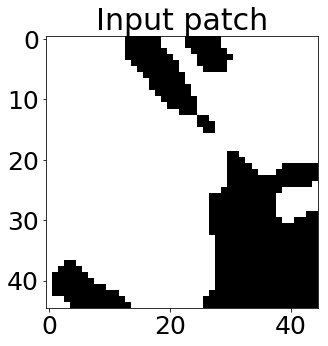

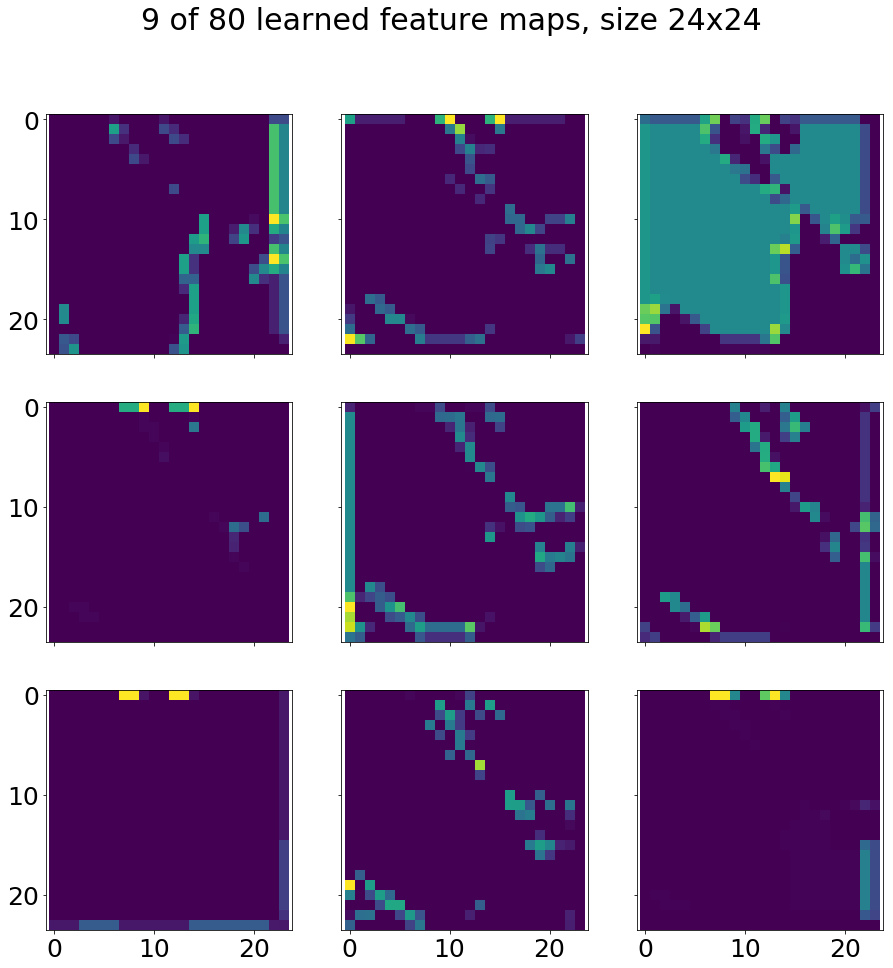

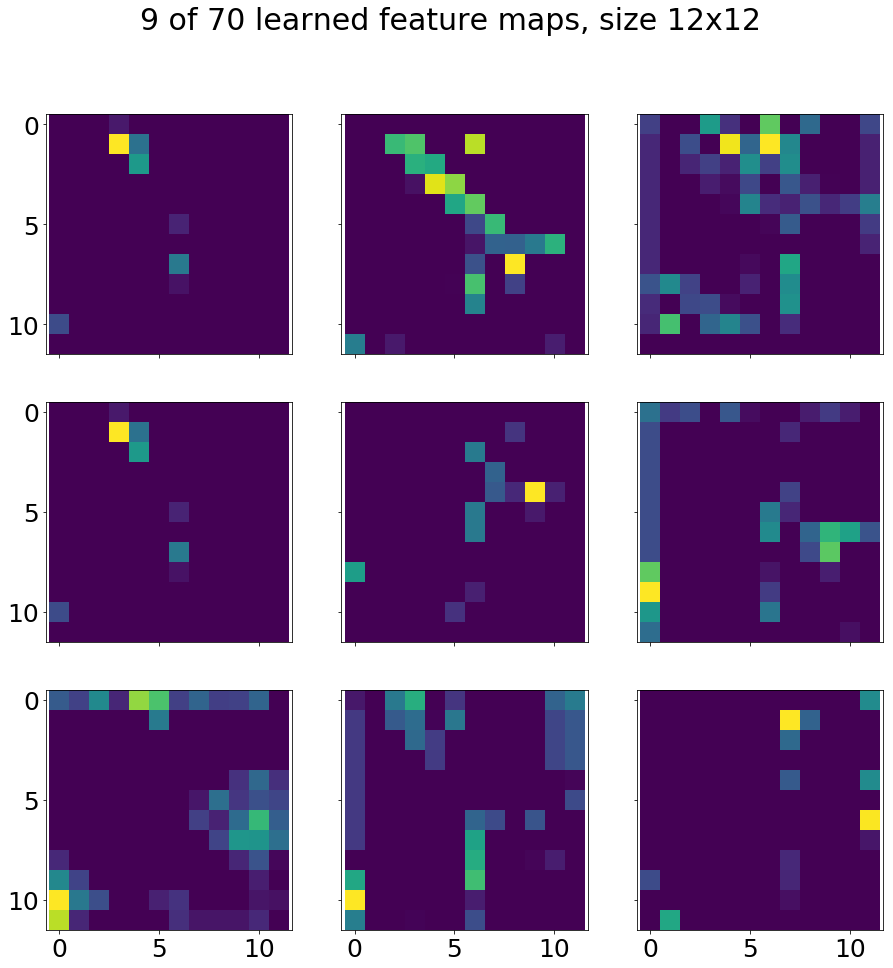

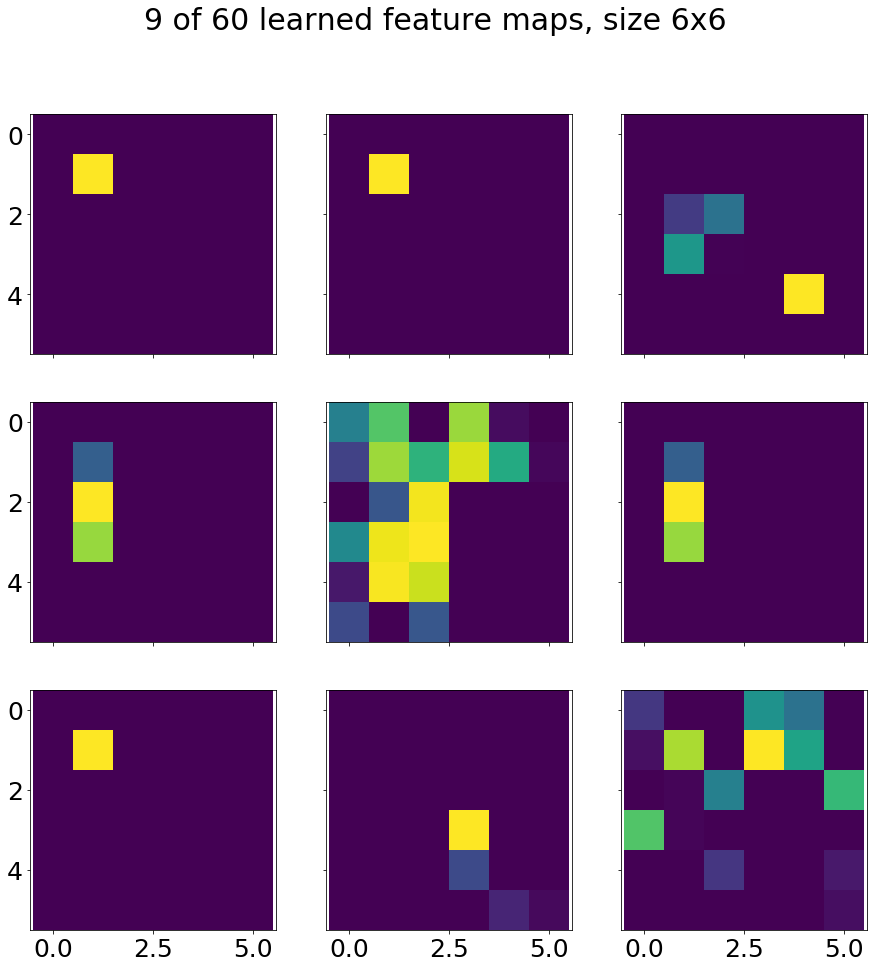

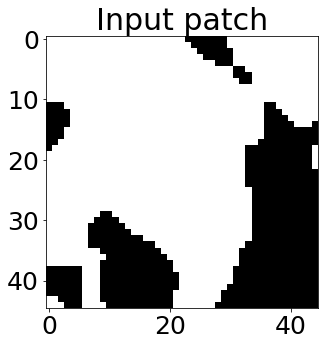

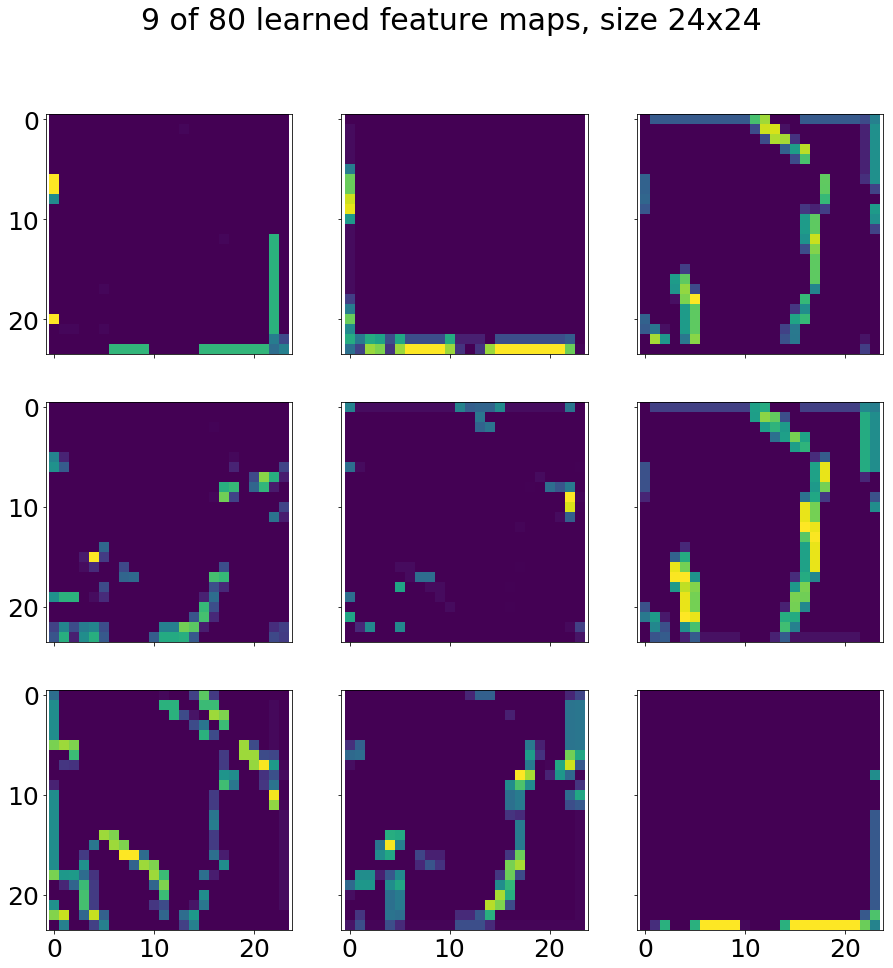

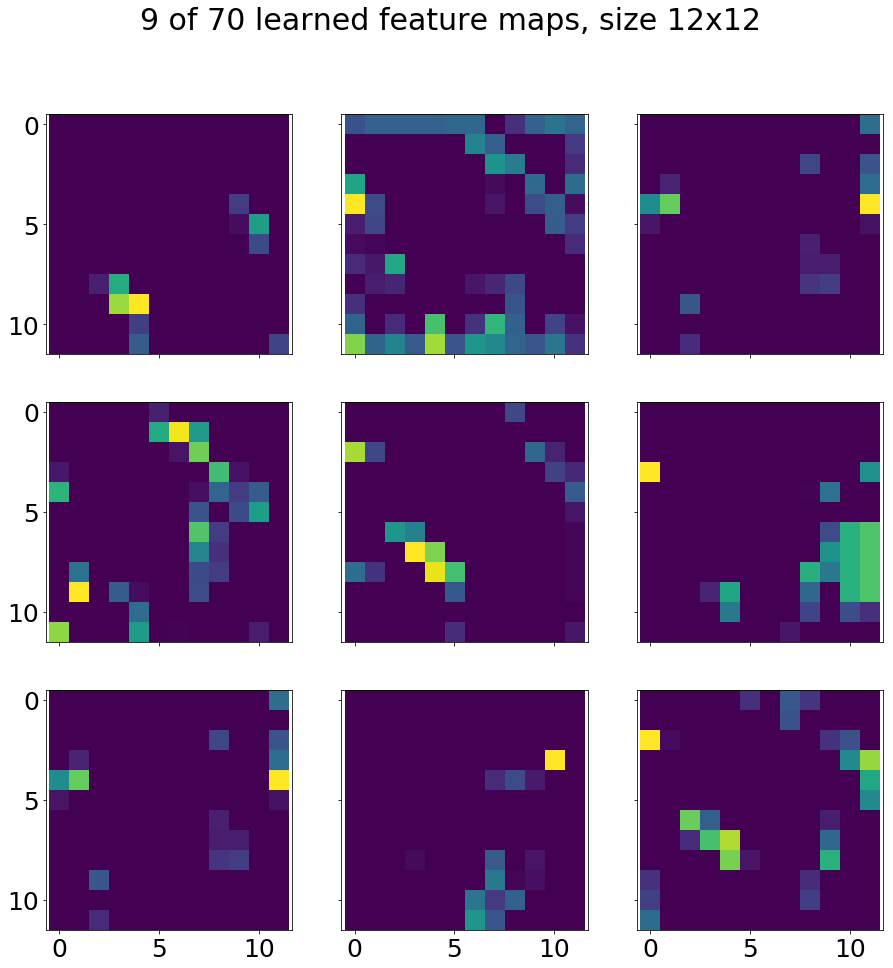

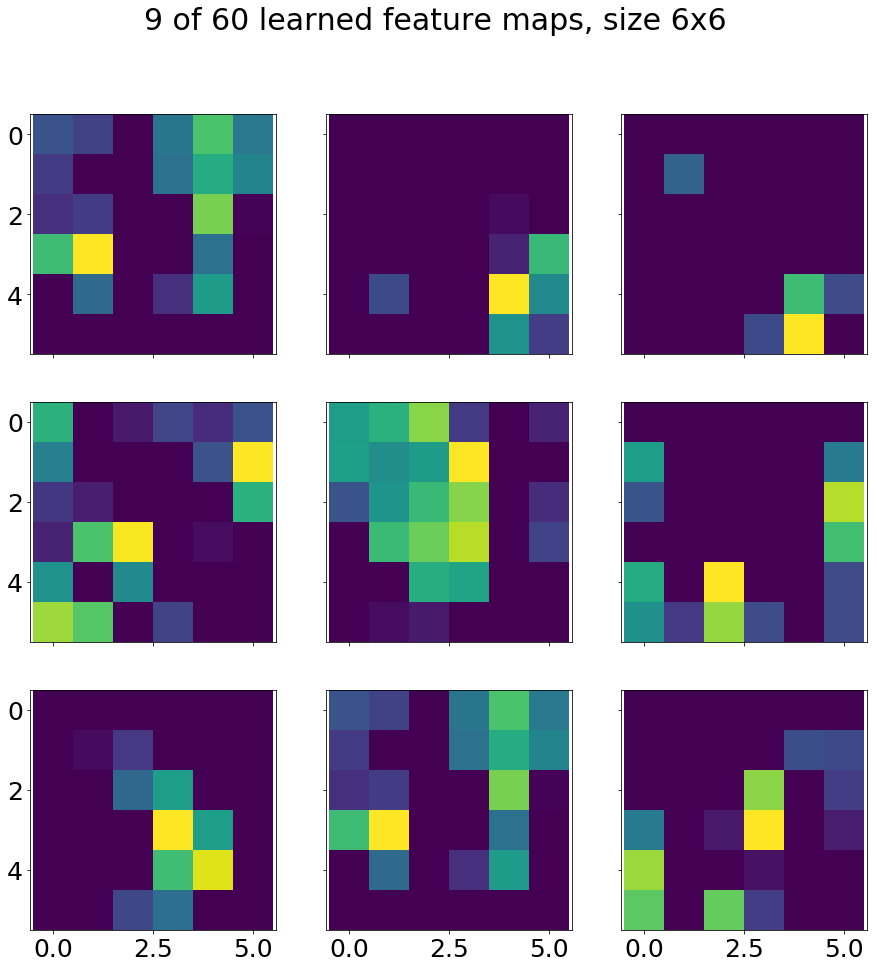

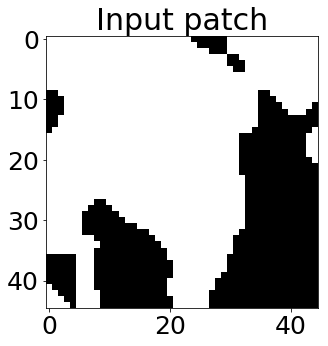

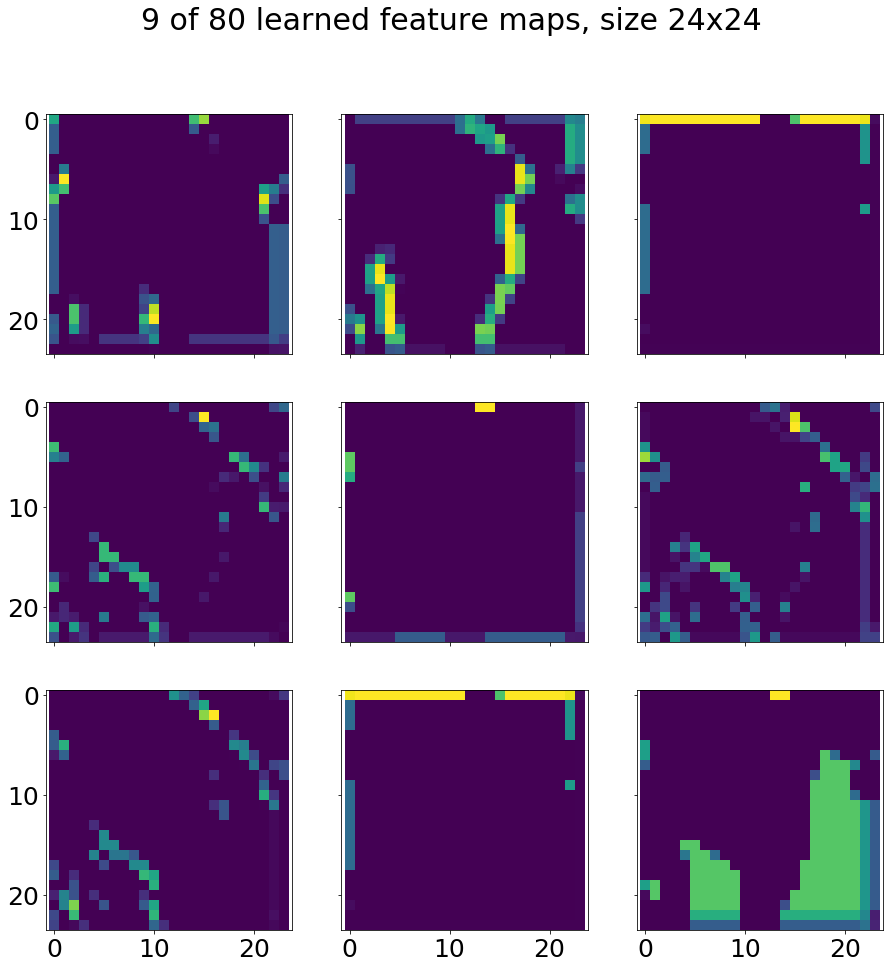

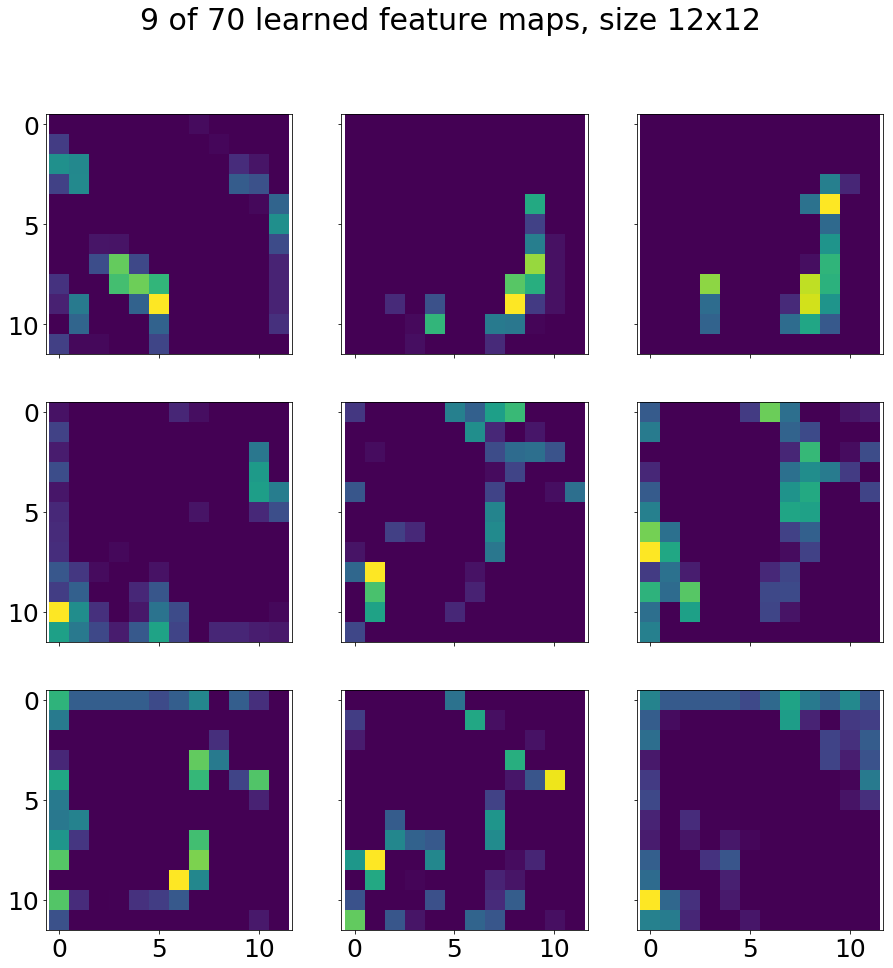

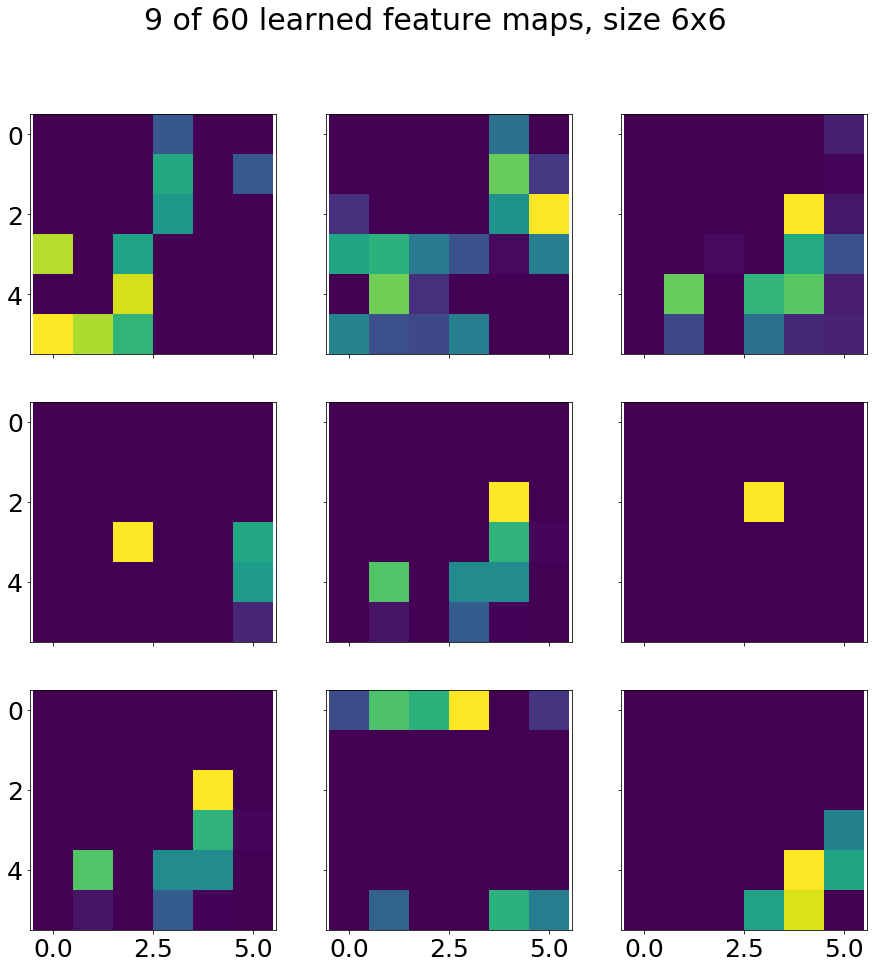

In [16]:


for pic_ind,picture in enumerate(get_patches(subsample_mask,filename)):
    if picture[0] is None:
        continue

    if pic_ind%125300==120: print ('making sample for: ',pic_ind)
    rowx,coly=picture[-1]
    
    draw_one(picture[0],'{}/pic_({},{})'.format(save_picdir,coly,rowx))
    #draw_one(picture[0][21:-21,21:-21], 'pic_({},{})_small{}'.format(coly, rowx,picture[1] ))
    
    plt.figure(figsize=(5,5))
    plt.imshow(picture[0],cmap='gray')
    plt.title('Input patch')
    
    patch_proc=make_split_map(picture[0],dopad=True)
    for inm in sorted(int_models.keys()):

        output=int_models[inm]([patch_proc ,0])[0]
        out_shape=output.shape
        output=output.transpose(3,1,2,0).reshape(out_shape[-1],out_shape[1],out_shape[2])
        out_inds=np.arange(output.shape[0],dtype=int).reshape(-1,1)



        sum_act=np.sum(output.reshape(-1,out_shape[1]*out_shape[2]),axis=1).reshape(-1,1)
        sum_inds=np.hstack((sum_act,out_inds))

        sum_sact=np.sum(save_out[inm].reshape(-1,\
            save_out[inm].shape[1]*save_out[inm].shape[2]),axis=1).reshape(-1,1)
        which_big=(sum_act>sum_sact).flatten()
        save_out[inm][which_big]=output[which_big]
        save_out[inm+"_in"][which_big]=np.broadcast_to(picture[0],(np.sum(which_big),)+picture[0].shape)

        if drawSmall:
            rand_draw_indi=np.random.choice(save_out[inm].shape[0],9)
            draw_someoutput(output[rand_draw_indi],
                save_picdir,draw_suffix='pic_({},{})_{}'.format(coly,rowx,inm))
            
            f, axarr= plt.subplots(3,3, sharex='col', sharey='row',figsize=(15,15))
            f.suptitle('9 of {0} learned feature maps, size {1}x{1}'.format(*save_out[inm].shape[:2]))
            for pind,(i,j) in enumerate(itertools.product(range(3),range(3))):
                axarr[i,j].imshow(output[rand_draw_indi[pind] ])





## Saving maximized feature maps

+ This code optionally saves the most activated feature maps,coming from a large input set.

+ The goal is to find **which convolutional kernels** specialize for **what type of input patches**.

+ All the visualizations are saved inside the `save_picdir` variable

Saving calculated maximums...
(80, 45, 45) (450, 450) 0.0
(80, 24, 24) (243, 243) 0.0
(70, 12, 12) (117, 117) 0.0
(70, 45, 45) (450, 450) 0.0
(60, 6, 6) (56, 56) 0.0
(60, 45, 45) (400, 400) 0.0
Every image is saved inside: "../test_data/visualise_maps"!


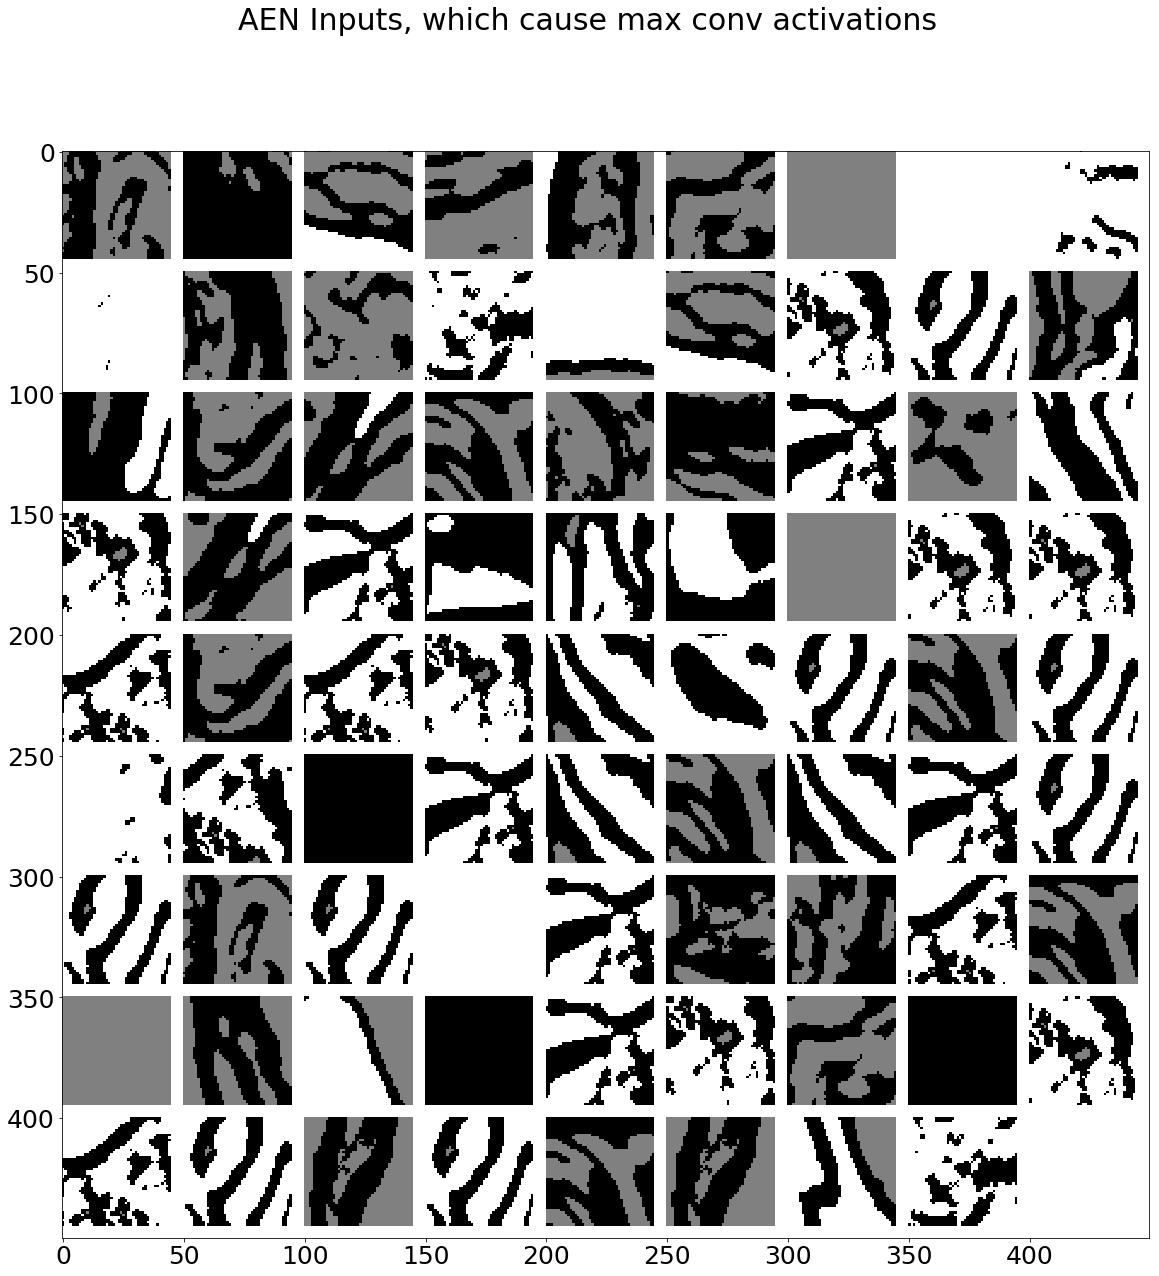

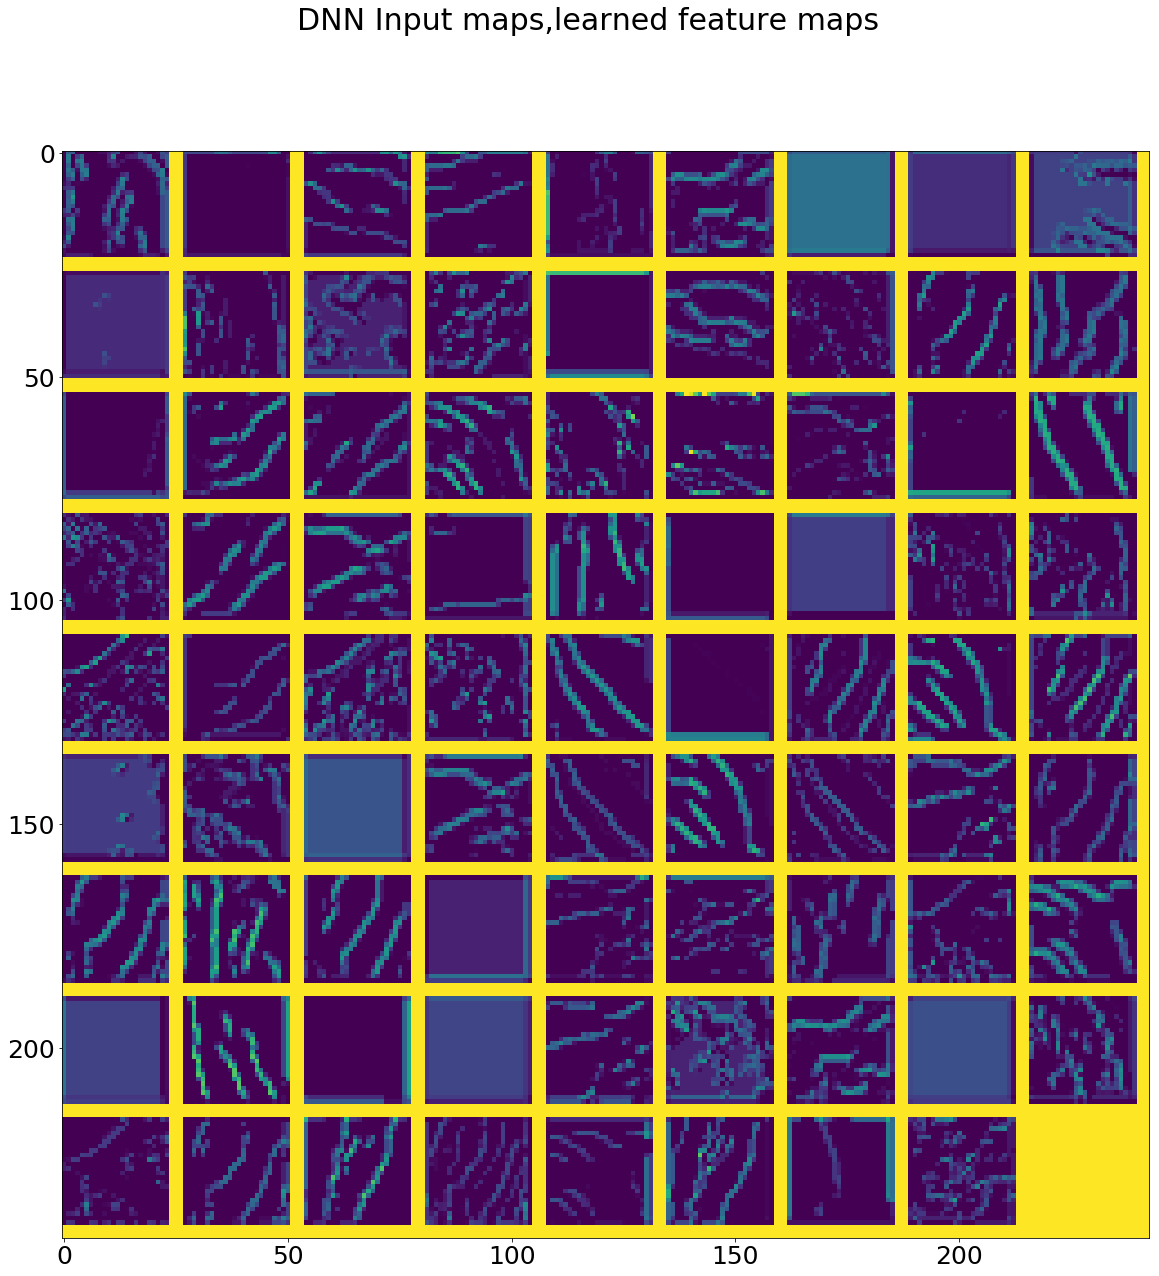

In [12]:
%matplotlib inline
drawSmall=False
mp.rcParams.update({'font.size' :25,'lines.linewidth':3,
                    'savefig.bbox':'tight','axes.labelsize':35})



if not drawSmall:
    print('Saving calculated maximums...')
    
    
    draw_someoutput( save_out['maxpooling2d_1_in'],save_picdir,chosen_cmap='gray',
                     draw_suffix='pic_layer_1_in'.format(),doShow=True)
    plt.suptitle('AEN Inputs, which cause max conv activations')

    
    draw_someoutput( save_out['maxpooling2d_1'],save_picdir,
                    draw_suffix='pic_layer_1'.format(),doShow=True)
    plt.suptitle('DNN Input maps,learned feature maps')


    
    draw_someoutput(save_out['maxpooling2d_2'],save_picdir,draw_suffix='pic_layer_2'.format())
    draw_someoutput(save_out['maxpooling2d_2_in'],save_picdir,chosen_cmap='gray'
                    ,draw_suffix='pic_layer_2_in'.format(),doShow=False)

    draw_someoutput(save_out['maxpooling2d_3'],save_picdir,draw_suffix='pic_layer_3'.format(),doShow=False)
    draw_someoutput(save_out['maxpooling2d_3_in'],save_picdir,chosen_cmap='gray'
                    ,draw_suffix='pic_layer_3_in'.format(),doShow=False)
    
    print('Every image is saved inside: "',save_picdir,'"!',sep='')